# Yelp Data Challenge - Restaurant Recommender

BitTiger DS501

Nov 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('/Users/Administrator/Desktop/Bittiger/501/Yelp Project/last_2_years_restaurant_reviews.csv')

In [3]:
df.head()

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2017-02-14,0,VETXTwMw6qxzOVDlXfe6Tg,5,went for dinner tonight. Amazing my husband ha...,0,ymlnR8UeFvB4FZL56tCZsA
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2017-12-04,0,S8-8uZ7fa5YbjnEtaW15ng,5,This was an amazing dinning experience! ORDER ...,0,9pSSL6X6lFpY3FCRLEH3og
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2016-08-22,1,1nK5w0VNfDlnR3bOz13dJQ,5,My husband and I went there for lunch on a Sat...,1,gm8nNoA3uB4In5o_Hxpq3g
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2016-09-13,0,N1Z93BthdJ7FT2p5S22jIA,3,Went for a nice anniversary dinner. Researched...,0,CEtidlXNyQzgJSdF1ubPFw
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2015-02-02,0,_Uwp6FO1X-avE9wqTMC59w,5,This place is first class in every way. Lobste...,0,-Z7Nw2UF7NiBSAzfXNA_XA


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [4]:
# Get business_id, user_id, stars for recommender

df_stars = df[['business_id', 'user_id', 'stars']]
df_stars.describe()

,stars
count,640718.000000
mean,3.821948
std,1.421403
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

**Q**: How do we recommend to these users anyways?

In [5]:
# To be implemented

df_user_counts=df_stars['user_id'].value_counts()
df_business_counts = df_stars['business_id'].value_counts()

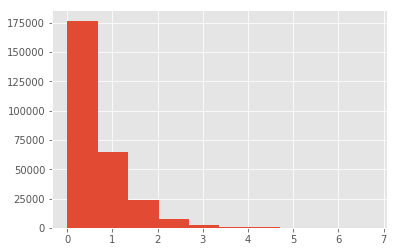

In [6]:
%matplotlib inline
df_user_counts.apply(np.log).hist()

In [7]:
np.percentile(df_user_counts, np.arange(10)*10)

array([1., 1., 1., 1., 1., 1., 1., 2., 2., 4.])

In [8]:
# Here we use the data with top 10% number of reviews

In [12]:
indFilter = df_user_counts[df_user_counts >4].index

df_stars_filtered = df_stars.set_index('user_id').loc[indFilter].reset_index()


#### Create utility matrix from records

In [13]:
# To be implemented

df_utility = pd.pivot_table(df_stars_filtered, values = 'stars',
                           index = 'user_id', columns = 'business_id', fill_value=0)
df_utility.info()

from scipy import sparse
utility_mat = sparse.csr_matrix(df_utility)

utility_mat.shape



<class 'pandas.core.frame.DataFrame'>
Index: 24754 entries, ---1lKK3aKOuomHnwAkAow to zzaq5Fn1U2Feut3dGxidNg
Columns: 4858 entries, --9e1ONYQuAa-CB_Rrw7Tw to zx_j6OuuHHa2afVoAZuLpA
dtypes: int64(4858)
memory usage: 917.7+ MB


(24754, 4858)

## 2. Item-Item similarity recommender

### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

In [15]:
# To be implemented

from sklearn.metrics.pairwise import cosine_similarity
from time import time
item_sim_mat = cosine_similarity(utility_mat.T)

least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

#Neighborhoods
neighborhoods_size = 200
neighborhoods = least_to_most_sim_indexes[:, -neighborhoods_size:]

In [20]:
index_user=100

#n_users = utility_mat.shape[0]
n_items = utility_mat.shape[1]

start_time = time()
items_rated_by_this_user = utility_mat[index_user].nonzero()[1]
#just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                   items_rated_by_this_user, 
                                   assume_unique=True)
#assume_unique speeds up intersection 
    out[item_to_rate]=utility_mat[index_user, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()
        
pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


[0. 0. 0. ... 0. 0. 0.]
Execution time: 2.241473 seconds


In [21]:
n=10

#Get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

#We want to exclude the items that have been rated by user
unrated_items_by_pred_rating = [
    item 
    for item in item_index_sorted_by_pred_rating
    if item not in items_rated_by_this_user]
business_reco_ind = unrated_items_by_pred_rating [:n]

print("The top %d business recommended for the user %s are %s"%(
n, (index_user, df_utility.index[index_user]), np.array(list(zip(business_reco_ind, df_utility.columns[business_reco_ind].values)))
))

The top 10 business recommended for the user (100, '-Ex9DZ2N0Kfs3fWEUOtP_g') are [['3857' 'm01nlmGzbS0TBB8NZxp3Yg']
 ['3549' 'hwJdv1tttvynXo2LZjJ6rg']
 ['1580' 'JXAMnijxRrW-jXHGvDJzzg']
 ['1985' 'P2cHq6apwK7z6XPaU24iJQ']
 ['695' '8FUzCm4Q13MJMX7N6ftmQw']
 ['180' '1CR2ddUcjYYwRd5JLtiRrw']
 ['3933' 'n0tnioUYabmpBrTwmIq08Q']
 ['1717' 'LIU7IcJtD9VieoIo__wd9Q']
 ['3918' 'mnU3iGsL55MCWXiWV3AcAQ']
 ['492' '5XORYO9raiXVZSGGPvjSmA']]


## 3. Matrix Factorization recommender

##### Compare two of the methods demoed in Practice Class: sklearn NMF, sklearn TruncatedSVD, or GraphLab
##### *Extra points for using GraphLab

In [26]:
##### sklearn NMP

In [24]:
from sklearn.decomposition import NMF

def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W=nmf.transform(M);
    H=nmf.components_;
    err=nmf.reconstruction_err_
    return W,H,err

#decompose
W,H,err = fit_nmf(utility_mat, 200)
print(err)
print(W.shape, H.shape)

1730.319927421931
(24754, 200) (200, 4858)


In [25]:
utility_mat_fitted = W.dot(H)

errs = np.array((utility_mat-utility_mat_fitted).flatten()).squeeze()
mask = np.array((utility_mat.todense()).flatten()).squeeze()>0

mse=np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

10.439761293152381
2.622998511602525


In [28]:
#get recommendations for one user
index_user=100
n=10
pred_ratings = utility_mat_fitted[index_user, :]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = utility_mat[index_user].nonzero()[1]

unrated_item_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                              if item not in items_rated_by_this_user]
business_reco_ind = unrated_items_by_pred_rating[:n]

print("The top %d business recommended for the user %s are %s" %(n, (index_user, df_utility.index[index_user]), np.array(list(zip(business_reco_ind, 
                                                                                                                                 df_utility.columns[business_reco_ind].values)))))




The top 10 business recommended for the user (100, '-Ex9DZ2N0Kfs3fWEUOtP_g') are [['3857' 'm01nlmGzbS0TBB8NZxp3Yg']
 ['3549' 'hwJdv1tttvynXo2LZjJ6rg']
 ['1580' 'JXAMnijxRrW-jXHGvDJzzg']
 ['1985' 'P2cHq6apwK7z6XPaU24iJQ']
 ['695' '8FUzCm4Q13MJMX7N6ftmQw']
 ['180' '1CR2ddUcjYYwRd5JLtiRrw']
 ['3933' 'n0tnioUYabmpBrTwmIq08Q']
 ['1717' 'LIU7IcJtD9VieoIo__wd9Q']
 ['3918' 'mnU3iGsL55MCWXiWV3AcAQ']
 ['492' '5XORYO9raiXVZSGGPvjSmA']]


In [29]:
####sklearn TruncatedSVD

In [30]:
from sklearn.decomposition import TruncatedSVD

def fit_uvd(M,k):
    #use TruncatedSVD to realize UVD
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)
    
    V = svd.components_
    U = svd.transform(M)
    # effectively, it's doing: U = M.dot(V.T)
    # we can ignore svd.singular_values_ for our purpose
    
    # why we can do this?
    # recall: 
    # SVD start from u*s*v=M => u*s=M*v.T, where M*v.T is our transformation above to get U in UVD
    # so the above U is effectively u*s in SVD
    # that's why U*V = u*s*v = M our original matrix
    # there are many ways to understand it!
    # here we by-passed singular values.
    
    return U,V,svd

#decompose
U,V,svd = fit_uvd(utility_mat, 400)

In [31]:
utility_mat_fitted = U.dot(V) # U*V

# recall: U = M.dot(V.T), then this is M.dot(V.T).dot(V)
# original M is transformed to new space, then transformed back
# this is another way to understand it!

# calculate errs
errs = np.array((utility_mat-utility_mat_fitted).flatten()).squeeze()
mask = np.array((utility_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

6.758581921362013
1.97195274515644


In [32]:
index_user = 100
n = 10

pred_ratings = utility_mat_fitted[index_user,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = utility_mat[index_user].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

business_reco_ind = unrated_items_by_pred_rating[:n]

print("The top %d business recommended for the user %s are %s"%(n, (index_user, df_utility.index[index_user]), np.array(list(zip(business_reco_ind, df_utility.columns[business_reco_ind].values)))))

The top 10 business recommended for the user (100, '-Ex9DZ2N0Kfs3fWEUOtP_g') are [['1281' 'FhIeCF6QrsLaRvAeu0oEPQ']
 ['2000' 'PChG1Dm0A6AXIXkXGVK8Fw']
 ['3540' 'hqvqLihniz0ynit9c36JHg']
 ['2284' 'So132GP_uy3XbGs0KNyzyw']
 ['4069' 'ozMd45nXHTCl3mdOwouwlw']
 ['3479' 'h3pMMRwqBjMeMtk0_qQzRQ']
 ['2432' 'UV2Jt8slktGu14gLZeNCjA']
 ['1601' 'JpgVl3d20CMRNjf1DVnzGA']
 ['4837' 'zdE82PiD6wquvjYLyhOJNA']
 ['195' '1SqLPgnZEVeVYDM-AuoFhg']]


## 4. Other recommenders (optional)

What are other ways you can build a better recommender?

* Other features (have you noticed there are other features in the Yelp dataset, e.g. tips, etc.?)
* Popularity-based
* Content-based
* Hybrid

In [34]:
####content_based

In [35]:
# only utilize business information when recommending them to user 
df.info()
df['business_id'].nunique()
df['review_id'].nunique()

df.head()
df.groupby(['business_id']).mean()

cat = df.groupby('business_id')['categories'].apply(np.unique)
cat.apply(len)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640718 entries, 0 to 640717
Data columns (total 12 columns):
business_id    640718 non-null object
name           640718 non-null object
categories     640718 non-null object
avg_stars      640718 non-null float64
cool           640718 non-null int64
date           640718 non-null object
funny          640718 non-null int64
review_id      640718 non-null object
stars          640718 non-null int64
text           640718 non-null object
useful         640718 non-null int64
user_id        640718 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 58.7+ MB


business_id
--9e1ONYQuAa-CB_Rrw7Tw    1
-1m9o3vGRA8IBPNvNqKLmA    1
-1vfRrlnNnNJ5boOVghMPA    1
-3zffZUHoY8bQjGfPSoBKQ    1
-8R_-EkGpUhBk55K9Dd4mg    1
-9YyInW1wapzdNZrhQJ9dg    1
-AD5PiuJHgdUcAK-Vxao2A    1
-ADtl9bLp8wNqYX1k3KuxA    1
-AGdGGCeTS-njB_8GkUmjQ    1
-BS4aZAQm9u41YnB9MUASA    1
-Bf8BQ3yMk8U2f45r2DRKw    1
-BmqghX1sv7sgsxOIS2yAg    1
-Bv-HHUs8aHzDrdWcZHn8w    1
-C8sSrFqaCxp51pyo-fQLQ    1
-CQokjildrY7UZezXCdEBw    1
-CbDQXiuKzPQ0_jiUz03aw    1
-EohS3nXZGl6odE9Lx5BSw    1
-FNquqGseSCVMWo7KbK-Tg    1
-FcZY7a7qgxTUlTvwuyJnQ    1
-G7MPSNBpxRJmtrJxdwt7A    1
-IWsoxH7mLJTTpU5MmWY4w    1
-JFVxwdVQfX207554dx1nw    1
-JfncbVURtvuzBbof40o1w    1
-Jo0rJr2mZxBVgaJqDs-TQ    1
-Jx2rd2rH7MlWfb9RMtCFQ    1
-K82LBrI3H0FVuhTbNDpRA    1
-LMycE26AortJDsbc8oXOg    1
-Le6cwbZL4tDZwNHwipfKg    1
-LzUYsR54hd8cCiYXTquRA    1
-MmAW2x9vMGuhVcALU7QRw    1
                         ..
z_46RY-L3vcMrH3-wxCp9w    1
zaxK3ea92mvEBRy-jttngg    1
zazLy5wo73tr5y9Oxjx36g    1
zb8kMYcte7WLcB-7CG3vNg    1
zbVJRIXE